In [47]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.generation import MaxPosteriorSampling
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [51]:
fun = Ackley(dim=10, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-10)
fun.bounds[1, :].fill_(15)
dim = fun.dim
lb, ub = fun.bounds


def eval_objective(x):
    
    print('inside eval_objective and x is',x)
    print(x.numpy()[0])
    print(x.numpy()[1])
    
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [52]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state


In [53]:
def get_initial_points(dim, n_pts):
    sobol = SobolEngine(dimension=dim, scramble=True)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [54]:


def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim, dtype=dtype, device=device)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next



In [55]:
batch_size = 4
n_init = 20  # 2*dim, which corresponds to 5 batches of 4

In [56]:


X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4


while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    #likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    likelihood = GaussianLikelihood()
    model = SingleTaskGP(X_turbo, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Create a batch
    X_next = generate_batch(
        state=state,
        model=model,
        X=X_turbo,
        Y=train_Y,
        batch_size=batch_size,
        n_candidates=N_CANDIDATES,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        acqf="ts",
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )



inside eval_objective and x is tensor([0.3969, 0.9312, 0.0147, 0.1211, 0.8608, 0.3638, 0.7718, 0.6985, 0.5482,
        0.8090], dtype=torch.float64)
0.3969269096851349
0.9311870336532593
inside eval_objective and x is tensor([0.8835, 0.3427, 0.7026, 0.6103, 0.1109, 0.8591, 0.2043, 0.0795, 0.3305,
        0.3578], dtype=torch.float64)
0.8835394978523254
0.3427472710609436
inside eval_objective and x is tensor([0.5801, 0.7161, 0.4025, 0.2638, 0.3498, 0.6954, 0.5199, 0.4048, 0.2221,
        0.1922], dtype=torch.float64)
0.5801422595977783
0.7161256670951843
inside eval_objective and x is tensor([0.0751, 0.0568, 0.8403, 0.7549, 0.6004, 0.2061, 0.4563, 0.7542, 0.8755,
        0.6474], dtype=torch.float64)
0.07505141943693161
0.05676354467868805
inside eval_objective and x is tensor([0.2393, 0.5108, 0.5962, 0.9844, 0.6684, 0.4695, 0.6516, 0.3020, 0.0033,
        0.4294], dtype=torch.float64)
0.2392599731683731
0.5107535719871521
inside eval_objective and x is tensor([0.7303, 0.2309, 0.1583, 

inside eval_objective and x is tensor([0.3270, 0.7803, 0.4912, 0.3553, 0.3851, 0.5265, 0.3655, 0.2768, 0.0174,
        0.5203], dtype=torch.float64)
0.3270173500831323
0.7803493505497322
inside eval_objective and x is tensor([0.4997, 0.5406, 0.3863, 0.5823, 0.5124, 0.4209, 0.3812, 0.4443, 0.0554,
        0.1242], dtype=torch.float64)
0.4996835196463323
0.5406439209974487
inside eval_objective and x is tensor([0.2539, 0.4319, 0.4455, 0.1924, 0.3552, 0.5553, 0.4584, 0.5925, 0.2506,
        0.5520], dtype=torch.float64)
0.2539108904334876
0.43194744284832365
inside eval_objective and x is tensor([0.2173, 0.5704, 0.4277, 0.4342, 0.3756, 0.4171, 0.7053, 0.5451, 0.3247,
        0.4906], dtype=torch.float64)
0.21732150534037584
0.5704001129051455
48) Best value: -1.13e+01, TR length: 8.00e-01
inside eval_objective and x is tensor([0.3133, 0.2678, 0.3822, 0.3046, 0.2558, 0.5615, 0.1746, 0.3270, 0.4785,
        0.7194], dtype=torch.float64)
0.31334774834917034
0.2677975030195144
inside eval_obj

inside eval_objective and x is tensor([0.4715, 0.5422, 0.4060, 0.5344, 0.3781, 0.4395, 0.3736, 0.4504, 0.4415,
        0.4832], dtype=torch.float64)
0.4714622069098315
0.5422284735889165
inside eval_objective and x is tensor([0.4887, 0.5473, 0.4094, 0.4431, 0.4815, 0.4070, 0.4116, 0.3782, 0.3381,
        0.4020], dtype=torch.float64)
0.48865823358477256
0.5473319556391085
inside eval_objective and x is tensor([0.3703, 0.4880, 0.3249, 0.3722, 0.4965, 0.4235, 0.4859, 0.4679, 0.5044,
        0.4824], dtype=torch.float64)
0.3703194475698458
0.48798968718804375
inside eval_objective and x is tensor([0.3094, 0.4415, 0.4092, 0.3421, 0.3984, 0.3946, 0.3406, 0.4183, 0.4153,
        0.4673], dtype=torch.float64)
0.30941826982781256
0.44153847097294807
92) Best value: -5.60e+00, TR length: 4.00e-01
inside eval_objective and x is tensor([0.3743, 0.3919, 0.2517, 0.3940, 0.2813, 0.3061, 0.3614, 0.3633, 0.3461,
        0.4383], dtype=torch.float64)
0.3743464534466275
0.39192264874402
inside eval_obje

inside eval_objective and x is tensor([0.3950, 0.3878, 0.4108, 0.4252, 0.4379, 0.3968, 0.3839, 0.4244, 0.3958,
        0.4261], dtype=torch.float64)
0.39502924738592754
0.3877940676017767
inside eval_objective and x is tensor([0.3778, 0.4096, 0.3969, 0.4108, 0.4205, 0.4099, 0.3880, 0.4267, 0.3741,
        0.4192], dtype=torch.float64)
0.37779440848575446
0.40958527713511833
inside eval_objective and x is tensor([0.3979, 0.3913, 0.3993, 0.4143, 0.3910, 0.4413, 0.4168, 0.4150, 0.3956,
        0.4272], dtype=torch.float64)
0.39785257750931713
0.3913388045673444
inside eval_objective and x is tensor([0.4032, 0.4173, 0.3853, 0.4122, 0.4127, 0.3904, 0.3935, 0.4311, 0.4040,
        0.3952], dtype=torch.float64)
0.40315159604512707
0.41726472272018567
136) Best value: -2.99e+00, TR length: 1.00e-01
inside eval_objective and x is tensor([0.4123, 0.4067, 0.3927, 0.4450, 0.4060, 0.4259, 0.4150, 0.4026, 0.4071,
        0.3952], dtype=torch.float64)
0.4123248414097201
0.4066557113309313
inside eval

inside eval_objective and x is tensor([0.3919, 0.3886, 0.3741, 0.3926, 0.4105, 0.3900, 0.3942, 0.3964, 0.3879,
        0.4077], dtype=torch.float64)
0.39193071170241855
0.38859070961190084
inside eval_objective and x is tensor([0.3836, 0.3860, 0.3807, 0.3893, 0.4107, 0.3955, 0.3972, 0.4009, 0.3939,
        0.3995], dtype=torch.float64)
0.3835941810007402
0.3860276175788272
inside eval_objective and x is tensor([0.4056, 0.3869, 0.3804, 0.3936, 0.4145, 0.3937, 0.4046, 0.4056, 0.3947,
        0.3874], dtype=torch.float64)
0.40558061712754234
0.38689916540058045
inside eval_objective and x is tensor([0.4139, 0.3909, 0.3897, 0.4005, 0.4071, 0.3893, 0.3862, 0.4053, 0.3903,
        0.3991], dtype=torch.float64)
0.4138631497059798
0.3908544410959267
180) Best value: -1.87e+00, TR length: 5.00e-02
inside eval_objective and x is tensor([0.4151, 0.3904, 0.3766, 0.4088, 0.4120, 0.4046, 0.3956, 0.3974, 0.4127,
        0.4113], dtype=torch.float64)
0.4151128065125792
0.3904267236652181
inside eval_o

inside eval_objective and x is tensor([0.3979, 0.3847, 0.3809, 0.3941, 0.3970, 0.4061, 0.4002, 0.3962, 0.3989,
        0.4047], dtype=torch.float64)
0.3978719054044387
0.38472963175165653
inside eval_objective and x is tensor([0.4002, 0.3859, 0.3785, 0.3951, 0.3949, 0.4043, 0.3899, 0.3961, 0.3997,
        0.4020], dtype=torch.float64)
0.40017409117864483
0.385870181319987
inside eval_objective and x is tensor([0.3963, 0.3835, 0.3777, 0.3934, 0.3988, 0.4010, 0.3981, 0.3972, 0.3993,
        0.3997], dtype=torch.float64)
0.3963042459269721
0.38351033262638157
inside eval_objective and x is tensor([0.4054, 0.3871, 0.3810, 0.3933, 0.3961, 0.4053, 0.3959, 0.3957, 0.3992,
        0.4011], dtype=torch.float64)
0.4054463405525492
0.38709322627297366
224) Best value: -1.68e+00, TR length: 1.25e-02
inside eval_objective and x is tensor([0.3982, 0.3952, 0.3822, 0.3909, 0.3966, 0.3980, 0.3911, 0.4034, 0.4081,
        0.3958], dtype=torch.float64)
0.39819038732507983
0.39515695686173924
inside eval_

inside eval_objective and x is tensor([0.3923, 0.3865, 0.4013, 0.3882, 0.3922, 0.4076, 0.3968, 0.4078, 0.4050,
        0.4006], dtype=torch.float64)
0.3923132254998584
0.38650250630690747
inside eval_objective and x is tensor([0.3920, 0.3893, 0.4009, 0.3862, 0.3928, 0.4054, 0.3928, 0.4074, 0.4072,
        0.4015], dtype=torch.float64)
0.39203728416543665
0.3893315410788837
inside eval_objective and x is tensor([0.3890, 0.3900, 0.3962, 0.3853, 0.3926, 0.4061, 0.3986, 0.4052, 0.4063,
        0.4011], dtype=torch.float64)
0.3890497982284059
0.39004887888376083
inside eval_objective and x is tensor([0.3884, 0.3871, 0.4003, 0.3855, 0.3965, 0.4092, 0.3976, 0.4082, 0.4039,
        0.4034], dtype=torch.float64)
0.3884179787533001
0.38712935943701254
268) Best value: -1.19e+00, TR length: 1.25e-02
inside eval_objective and x is tensor([0.3913, 0.3884, 0.4037, 0.3873, 0.3951, 0.4083, 0.4014, 0.3987, 0.4079,
        0.4032], dtype=torch.float64)
0.3912889518907696
0.38838094704743203
inside eval_

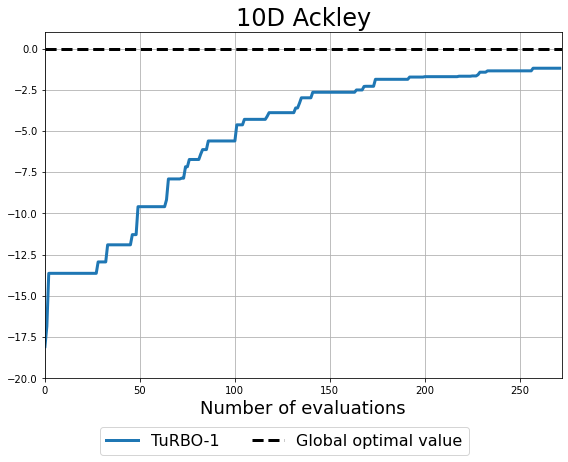

In [57]:


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline


names = ["TuRBO-1"]
runs = [Y_turbo]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-20, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()

